In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from modules.midas.utils import *

In [3]:
input_prefix = Path("input")
output_prefix = Path("output")

gt_dep_prefix = Path("ground_truth")
gt_spdep_prefix = Path("sparse_depth")
rgb_prefix = Path("image")

ga_dep_prefix = Path("ga_depth")
sml_dep_prefix = Path("sml_depth")

scene = "classroom4"
# scene = "birthplace_of_internet"
imname = "1552695831.4496.png"

In [4]:
dep1 = np.array(cv2.imread((input_prefix / scene / gt_dep_prefix / imname).as_posix(), cv2.IMREAD_UNCHANGED), dtype=np.float32)
dep1.min(), dep1.max()

(0.0, 547.0)

In [5]:
dep1.dtype

dtype('float32')

In [6]:
dep1_s = dep1 / 256
dep1_s.min(), dep1_s.max()

(0.0, 2.1367188)

In [7]:
gt_rgb1 = read_image((input_prefix / scene / rgb_prefix / imname).as_posix())
gt_dep1 = np.array(Image.open((input_prefix / scene / gt_dep_prefix / imname).as_posix()), dtype=np.float32) / 256.0
gt_spdep1 = np.array(Image.open((input_prefix / scene / gt_spdep_prefix / imname).as_posix()), dtype=np.float32) / 256.0

validity_map = np.array(Image.open((input_prefix / scene / "validity_map" / imname).as_posix()), dtype=np.float32)
assert(np.all(np.unique(validity_map) == [0, 256]))
validity_map[validity_map <= 0] = 1

ga_dep1 = read_pfm((output_prefix / scene / ga_dep_prefix / imname.replace("png", "pfm")).as_posix())[0]
sml_dep1 = read_pfm((output_prefix / scene / sml_dep_prefix / imname.replace("png", "pfm")).as_posix())[0]

In [8]:
print(gt_dep1.min(), gt_dep1.max())
print(gt_spdep1.min(), gt_spdep1.max())
print(ga_dep1.min(), ga_dep1.max())
print(sml_dep1.min(), sml_dep1.max())

0.0 2.1367188
0.0 1.984375
0.5281767 1.0442885
0.48063424 1.4010633


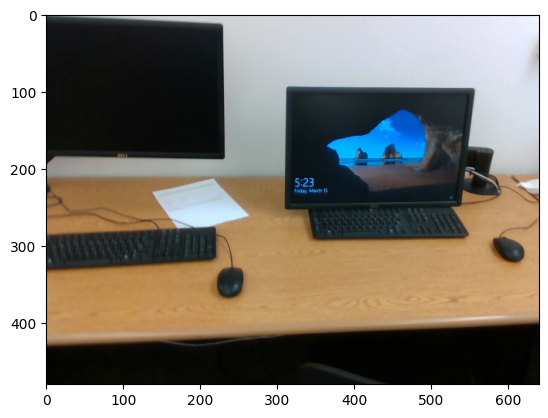

In [9]:
plt.imshow(gt_rgb1)

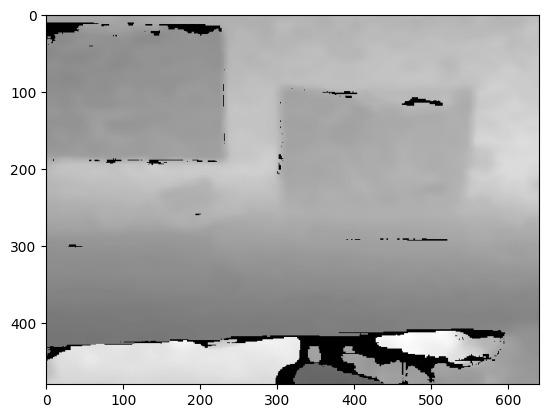

In [10]:
plt.imshow(gt_dep1, cmap='gray')

In [11]:
import pipeline

method = pipeline.VIDepth(
        depth_predictor="dpt_beit_large_512", 
        nsamples=150, 
        sml_model_path="weights/sml_model.dpredictor.dpt_beit_large_512.nsamples.150.ckpt", 
        min_pred=0.1, 
        max_pred=15.0,
        min_depth=0.2, 
        max_depth=8.0, 
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )

/home/keunmo/anaconda3/envs/marigold/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Using cache found in /home/keunmo/.cache/torch/hub/intel-isl_MiDaS_master
/home/keunmo/anaconda3/envs/marigold/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading weights:  weights/sml_model.dpredictor.dpt_beit_large_512.nsamples.150.ckpt


Using cache found in /home/keunmo/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [13]:
output = method.run(
    input_image=gt_rgb1,
    input_sparse_depth=gt_spdep1,
    validity_map=validity_map,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [14]:
ga_dep1 = output["ga_depth"]
sml_dep1 = output["sml_depth"]

In [15]:
ga_dep1.min(), ga_dep1.max()

(0.5281767, 1.0442885)

In [16]:
ga_dep1_d = 1.0 / ga_dep1

In [17]:
ga_dep1_d.min(), ga_dep1_d.max()

(0.95758975, 1.8933057)

In [18]:
sml_dep1.min(), sml_dep1.max()

(0.48063424, 1.4010633)

In [19]:
sml_dep1_d = 1.0 / sml_dep1

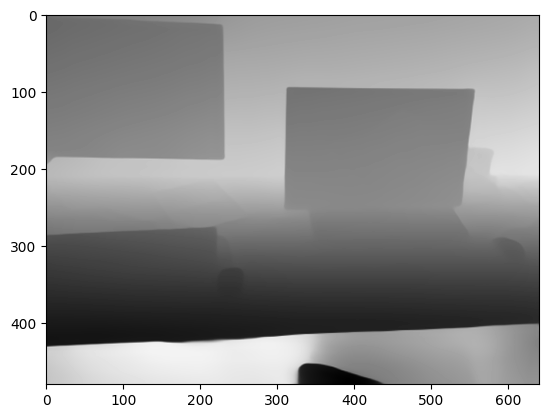

In [20]:
plt.imshow(ga_dep1_d, cmap='gray')

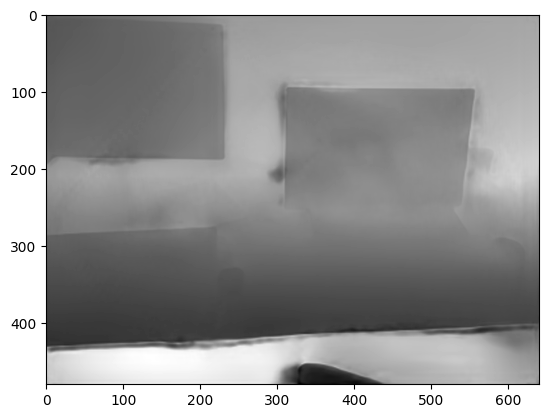

In [21]:
plt.imshow(sml_dep1_d, cmap='gray')

In [22]:
from modules.estimator import LeastSquaresEstimator

Visualize GT depth BackProjection

In [23]:
with open((input_prefix / scene / "K.txt")):
    K = np.loadtxt((input_prefix / scene / "K.txt"))
fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
u, v = np.meshgrid(np.arange(gt_dep1.shape[1]), np.arange(gt_dep1.shape[0]))
x = (u - cx) * gt_dep1 / fx
y = (v - cy) * gt_dep1 / fy
pts3d = np.stack([x, y, gt_dep1], axis=-1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(gt_rgb1.reshape(-1, 3))
o3d.visualization.draw_geometries([pcd])

Visualize GA depth BackProjection

In [24]:
x = (u - cx) * ga_dep1_d / fx
y = (v - cy) * ga_dep1_d / fy
pts3d = np.stack([x, y, ga_dep1_d], axis=-1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(gt_rgb1.reshape(-1, 3))
o3d.visualization.draw_geometries([pcd])

In [25]:
x = (u - cx) * sml_dep1_d / fx
y = (v - cy) * sml_dep1_d / fy
pts3d = np.stack([x, y, sml_dep1_d], axis=-1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(gt_rgb1.reshape(-1, 3))
o3d.visualization.draw_geometries([pcd])

GT depth and sparse depth use just metric depth. NOT INVERSE DEPTH!!!

In [26]:
ga_dep1[0].min(), ga_dep1[0].max()

(0.5770404, 0.73096436)

In [27]:
sml_dep1[0].min(), sml_dep1[0].max()


(0.5564102, 0.84724176)

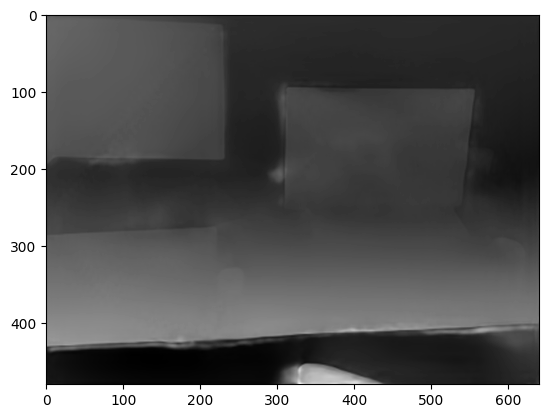

In [28]:
plt.imshow(sml_dep1, cmap='gray')

In [29]:
sml_dep1.min(), sml_dep1.max()

(0.48063424, 1.4010633)

### In LeastSquareEstimator, we calc scale and shift in inverse depth space.  
* LSE input estimate(dense depth): inv estimate depth  
* LSE input target(sparse depth): inv sparse depth

Do multi view depth img with gt depth and gt pose

In [30]:
from read_write_model import read_cameras_binary, read_images_binary, read_points3D_binary, read_model, qvec2rotmat

In [31]:
input_prefix = Path("dataset/replica_capture/room_0_traj1_plus2")

model_path = input_prefix / "sparse/loftr/sfm"

dep_prefix = input_prefix / "depths"
rgb_prefix = input_prefix / "images"

im1 = "frame000001.jpg"
im2 = "frame000002.jpg"

In [32]:
gt_rgb1 = read_image((rgb_prefix / im1).as_posix())
gt_dep1 = np.array(Image.open((dep_prefix / im1.replace('frame', 'depth').replace('jpg', 'png')).as_posix())) / 65535 * 10.0
# gt_dep1 = np.array(Image.open((dep_prefix / im1.replace('frame', 'depth').replace('jpg', 'png')).as_posix())) / 2**16 * 10.0

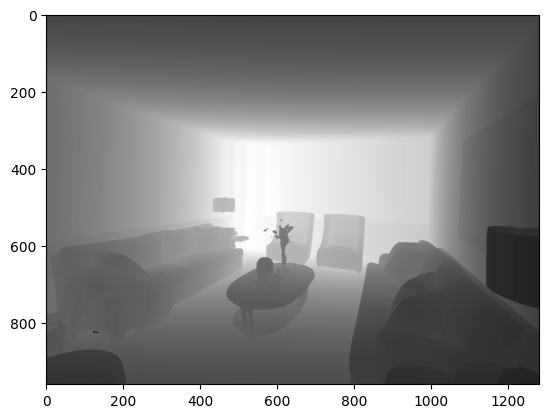

In [33]:
plt.imshow(gt_dep1, cmap='gray')

In [34]:
gt_dep1.min(), gt_dep1.max()

(0.0, 6.465857938506142)

In [35]:
cv2.imwrite("depth_test.png", (gt_dep1 * 256).astype(np.uint16))
write_pfm("depth_test.pfm", gt_dep1.astype(np.float32))

dep_test = np.array(Image.open("depth_test.png")) / 256.0


In [36]:
dep_test = np.array(Image.open("depth_test.png")) / 256.0
dep_test.min(), dep_test.max()

(0.0, 6.46484375)

In [37]:
gt_dep1.dtype

dtype('float64')

In [38]:
write_pfm("depth_test.pfm", dep_test.astype(np.float32))
dep_test2, _ = read_pfm("depth_test.pfm")
dep_test2.min(), dep_test2.max()

(0.0, 6.4648438)

In [39]:
cameras = read_cameras_binary((model_path / "cameras.bin").as_posix())

In [40]:
# with open((input_prefix / scene / "K.txt")):
#     K = np.loadtxt((input_prefix / scene / "K.txt"))
# fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
cam = cameras[0]
fx, fy, cx, cy = cam.params
u, v = np.meshgrid(np.arange(gt_dep1.shape[1]), np.arange(gt_dep1.shape[0]))
x = (u - cx) * gt_dep1 / fx
y = (v - cy) * gt_dep1 / fy
pts3d = np.stack([x, y, gt_dep1], axis=-1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(gt_rgb1.reshape(-1, 3))
o3d.visualization.draw_geometries([pcd])

In [41]:
images = read_images_binary((model_path / "images.bin").as_posix())
points3D = read_points3D_binary((model_path / "points3D.bin").as_posix())

In [42]:
im1_ = images[1]

In [43]:
# project 3d points to depth map
def pts3d_to_sparse_depth(cam, img, pt3d, depth_scale=1):
    def projection(R, t, K, pts3d):
        extrinsic = np.hstack((R, t[:, None]))
        proj_mat = K @ extrinsic
        pts2d = proj_mat @ np.append(pts3d, 1)
        pts2d = (pts2d / pts2d[2])[:2]
        return pts2d.round()
    fx, fy, cx, cy = cam.params
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    R = qvec2rotmat(img.qvec)
    t = img.tvec
    img_pt3dIds = img.point3D_ids[img.point3D_ids != -1]
    img_pt3ds = np.array([pt3d[pt3dId].xyz for pt3dId in img_pt3dIds])
    sparse_depth = np.zeros((cam.height, cam.width))
    for img_pt3d in img_pt3ds:
        u, v = projection(R, t, K, img_pt3d)
        z_depth = (R @ img_pt3d + t)[2]
        if 0 <= u < cam.width and 0 <= v < cam.height:
            sparse_depth[int(v), int(u)] = z_depth
    # depth_scale = 65535 * 0.1
    sparse_depth = sparse_depth * depth_scale
    return sparse_depth

In [59]:
sparse_dep = pts3d_to_sparse_depth(cam, im1_, points3D)

In [45]:
sparse_dep.min(), sparse_dep.max()

(0.0, 26.242331929680336)

In [46]:
sparse_dep.dtype

dtype('float64')

In [47]:
cv2.imwrite("spdepth_test.png", (sparse_dep * 256).astype(np.uint16))
write_pfm("spdepth_test.pfm", sparse_dep.astype(np.float32))

spdep_test = np.array(Image.open("spdepth_test.png")) / 256.0

In [48]:
sp_dep4 = cv2.imread("sparse_dep4.png", cv2.IMREAD_UNCHANGED)
sp_dep4.min(), sp_dep4.max()

(0, 65535)

In [49]:
sp_dep5 = np.array(Image.open("sparse_dep4.png"), dtype=np.float32) / 256.0
sp_dep5.min(), sp_dep5.max()

(0.0, 255.9961)

In [60]:
cam = cameras[0]
fx, fy, cx, cy = cam.params
u, v = np.meshgrid(np.arange(sparse_dep.shape[1]), np.arange(sparse_dep.shape[0]))
x = (u - cx) * sparse_dep / fx
y = (v - cy) * sparse_dep / fy
pts3d = np.stack([x, y, sparse_dep], axis=-1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(gt_rgb1.reshape(-1, 3))
o3d.visualization.draw_geometries([pcd])

In [51]:
sparse_dep.shape

(960, 1280)

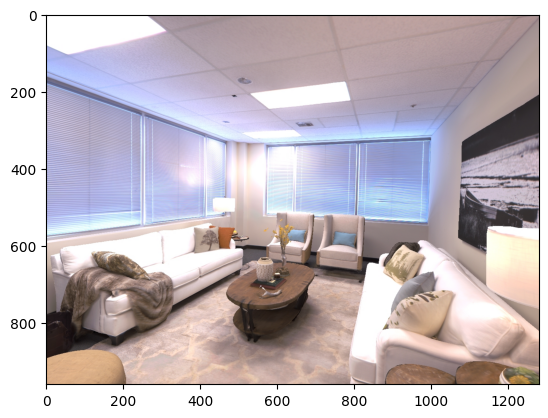

In [52]:
plt.imshow(gt_rgb1)

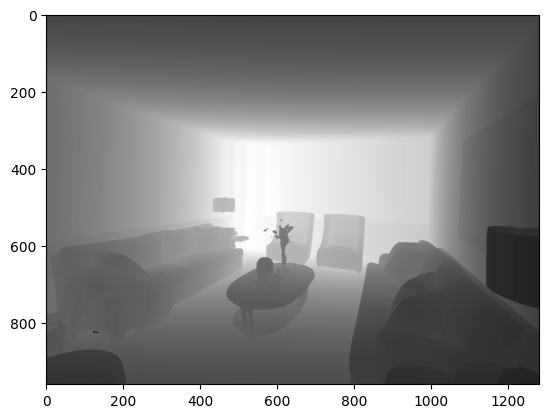

In [53]:
plt.imshow(gt_dep1, cmap='gray')

In [54]:
validity_map = np.ones_like(gt_dep1)

In [55]:
output = method.run(
    input_image=gt_rgb1,
    input_sparse_depth=sparse_dep,
    validity_map=validity_map,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

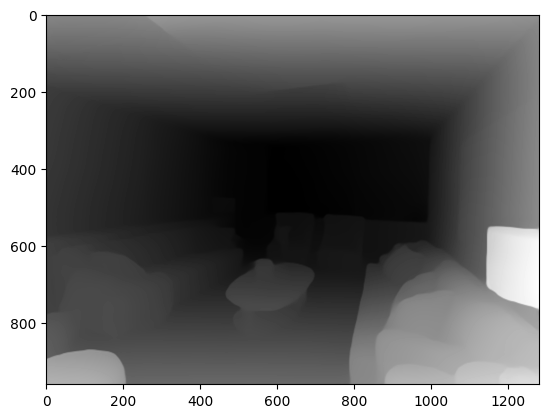

In [56]:
plt.imshow(output['ga_depth'], cmap='gray')

In [57]:
ga_dep2 = 1 / output['ga_depth']

cam = cameras[0]
fx, fy, cx, cy = cam.params
u, v = np.meshgrid(np.arange(sparse_dep.shape[1]), np.arange(sparse_dep.shape[0]))
x = (u - cx) * ga_dep2 / fx
y = (v - cy) * ga_dep2 / fy
pts3d = np.stack([x, y, ga_dep2], axis=-1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3d.reshape(-1, 3))
pcd.colors = o3d.utility.Vector3dVector(gt_rgb1.reshape(-1, 3))
o3d.visualization.draw_geometries([pcd])

In [58]:
o3d.visualization.draw_geometries([pcd])